In [1]:
%%capture
import numpy as np
import pandas as pd
!pip install openpyxl
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
for_r = 119
bandwidth = 4
#75 for l (and r=30) had good results and constant with different iterations
#for r = 30 and bandwith = 2 yielded only two missclassified positives
#but maybe lucky random state
#probably overfits (?) too much

In [3]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [4]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
list_elements_failed = list(list_failed['MAX'])
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)
whole_data = whole_data.drop(['PU_label','year'],axis=1)
M_elements = pd.get_dummies(whole_data['M'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M','A','X'],axis=1)
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,x_group,
                       a_group,m_group],axis=1)
number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)


data_norm['class'] = whole_data['class'].copy()

diff_z = list(data_norm.columns)
retained_features = list(data_norm.columns)

for feat in diff_z:
    if len(feat) > 5:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)
    elif 'x_g' in i:
        list_dummies.append(i)
    elif 'a_g' in i:
        list_dummies.append(i)
    elif 'm_g' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [5]:
#let's stick with 4 clusters, seems well enough
#turns out it's not because the positive are too spread

In [6]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1

positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

n_cluster = 8
clusterized_data = KMeans(n_clusters=n_cluster).fit(data_norm.to_numpy()[:,:-2])
data_norm['cluster'] = clusterized_data.labels_

list_of_ratio = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_ratio[i] = data_norm[data_norm['cluster'] == i]['class'].sum()

list_of_ratio = data_norm.groupby('cluster')['class'].sum()
#same code as before but here we use the class because it is 0 or 1
positive_cluster = np.argmax(list_of_ratio)
negative_cluster = np.argmin(list_of_ratio)

In [7]:
ranked = data_norm.groupby('cluster').sum().sort_values(by='class')['class']

In [8]:
ranked = pd.DataFrame(ranked)

In [9]:
df_unlab_pop = data_norm[data_norm['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
list_of_pop.columns = ['pop']

list_of_pop = ranked.merge(list_of_pop,how='left',right_index=True,left_index=True)

list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [10]:
reliable_positives = data_norm[data_norm['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*for_r)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = data_norm[data_norm['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

In [11]:
reliable_negatives = reliable_negatives.head(n=n_positives*for_r)

In [12]:
#Step of initialization of labels
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = data_norm.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

In [13]:
gamma = 1
good_ratio = 1/for_r
max_iter = 10
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data])
up_data_np = updated_data.to_numpy()[:,:-4].copy()
positive_index_list = list(data_norm[data_norm['class'] == 1].index)

In [14]:
right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
#computation of the matrix to det the coeffs so put it here to avoid doing it each time
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=bandwidth)*labels[0,i]*labels[0,k]
            omega[k,i] = omega[i,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    updated_data['to_det_b'] = np.zeros(n_samples)
    count_for_loop = 0
    for i in updated_data.index:
        updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                               y=up_data_np[count_for_loop,:],
                                                                               l_squared=bandwidth).reshape(-1,1))
        count_for_loop += 1
    to_det_b_arr = np.array(updated_data['to_det_b']).copy()
    b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
    
    updated_data['check_array'] = np.zeros(n_samples)
    count_diff = 0
    
    for i in updated_data.index:
        if i in positive_index_list:
            updated_data.loc[i,'check_array'] = 1
        else:
            updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
            if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                count_diff += 1
    
    if count_diff == 0:
        break
    else:
        updated_data['relab'] = updated_data['check_array'].copy()

In [15]:
test_results = np.zeros(positive_samples.shape[0])
test_set = positive_samples.to_numpy()[:,:-2]

In [16]:
for i in range(positive_samples.shape[0]):
    test_results[i] = np.sign(np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                    y=test_set[i,:],
                                                                    l_squared=bandwidth).reshape(-1,1))-b)

In [17]:
true_positives = 0
for i in range(positive_samples.shape[0]):
    if test_results[i] == 1:
        true_positives += 1

In [18]:
recall = true_positives/positive_samples.shape[0]

In [19]:
#'V4AlC3' 'Nb4AlC3' are missclassified
#'Ta4AlC3' is the 'frontier', it's the one that defines 'r'

In [20]:
number_of_predicted_positives = 0
for i in updated_data.drop(labels=list(positive_samples.index),axis=0).index:
    if updated_data.loc[i,'check_array'] == 1:
        number_of_predicted_positives += 1

In [21]:
weird_metric = (recall**2)/(number_of_predicted_positives/updated_data.drop(labels=list(positive_samples.index),axis=0).shape[0])

In [22]:
ordered_pred_df = updated_data[updated_data['check_array'] == 1].sort_values(by='to_det_b',ascending=False)

In [23]:
ordered_pred_df.to_csv('it_ls_svm_all_features.csv')

In [24]:
list_of_pos = list(positive_samples.index)

just_for_plot = updated_data.filter(['to_det_b'],axis=1)
df_to_plot = whole_data.merge(just_for_plot,how='left',left_index=True,right_index=True)

df_to_plot = df_to_plot.filter(items=list(ordered_pred_df.index),axis=0)
df_to_plot['final_relab'] = np.sign(df_to_plot['to_det_b'].to_numpy() - b)
pred_pos = df_to_plot[df_to_plot['final_relab']==1]
true_pos_to_plot = pred_pos[pred_pos['class']==1]

df_no_pos = whole_data.drop(labels=list(pred_pos.index),axis=0)
df_false_negatives = df_no_pos[df_no_pos['class'] == 1]


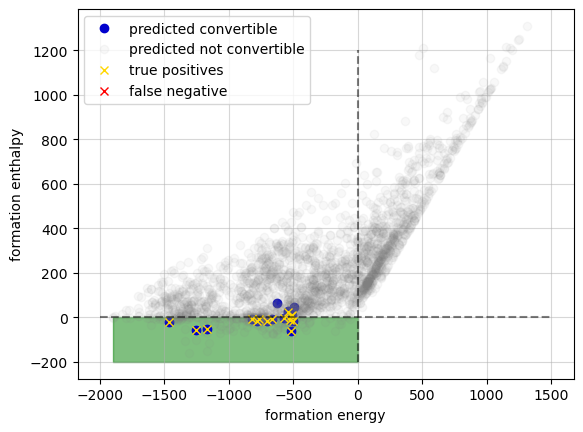

In [25]:
fig, ax = plt.subplots()

ax.plot(pred_pos['dEf'].to_numpy(),pred_pos['dH'].to_numpy(),'o', color='mediumblue', alpha=1,
         label='predicted convertible')
ax.plot(df_no_pos['dEf'].to_numpy(),df_no_pos['dH'].to_numpy(),'o',color='gray',alpha=0.05,
         label='predicted not convertible')
ax.plot(true_pos_to_plot['dEf'],true_pos_to_plot['dH'], 'x', color='gold',
        label='true positives')
ax.plot(df_false_negatives['dEf'],df_false_negatives['dH'], 'x', color='red',
        label='false negative')
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.fill_between(np.linspace(np.min(df_no_pos['dEf'].to_numpy()),0,2,endpoint=True),y1=-200,y2=0,color='green',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
#ax.set_title('it ls svm with all features')
plt.legend()
plt.savefig('it_ls_svm_pred_l_50_r_10_corr.png')

In [26]:
updated_data['score'] = updated_data['to_det_b'] - b

In [27]:
data_to_hist = updated_data.drop(list_of_pos,axis=0)
data_to_hist = data_to_hist.sort_values(by='score',ascending=True)

In [28]:
"""
fig, ax = plt.subplots()
ax.bar(x=data_to_hist.index,
       height=data_to_hist['score'])
ax.set_title('plot of the scores of the not known MXene')
"""

"\nfig, ax = plt.subplots()\nax.bar(x=data_to_hist.index,\n       height=data_to_hist['score'])\nax.set_title('plot of the scores of the not known MXene')\n"

In [29]:
tree_imp_feat_post = RandomForestClassifier(n_estimators=1000).fit(X=data_to_hist.drop(['class','label',
                                                               'cluster','relab','to_det_b',
                                                               'score','check_array'],axis=1),y=data_to_hist['check_array'])

In [30]:
df_for_imp_feat = pd.DataFrame(tree_imp_feat_post.feature_importances_)

In [31]:
df_for_imp_feat.index = data_to_hist.drop(['class','label','cluster',
                                           'relab','to_det_b','score',
                                           'check_array'],axis=1).columns

In [32]:
df_for_imp_feat.columns = ['imp_feat_value']

In [33]:
df_for_imp_feat = df_for_imp_feat.sort_values(by='imp_feat_value',ascending=False)

In [34]:
df_for_imp_feat['color'] = ['cornflowerblue']*df_for_imp_feat.shape[0]

In [35]:
df_for_imp_feat.loc['dH','color'] = 'lightcoral'
df_for_imp_feat.loc['dEf','color'] = 'lightcoral'

In [36]:
first_features = df_for_imp_feat.index[25]

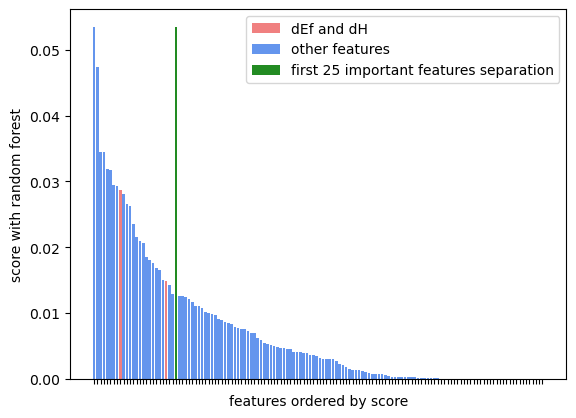

In [37]:
fig, ax = plt.subplots()
ax.bar(x=df_for_imp_feat.index,
       height=df_for_imp_feat['imp_feat_value'],color=df_for_imp_feat['color'])
ax.set(xticklabels=[])
ax.bar(first_features,height=np.max(df_for_imp_feat['imp_feat_value']),color='forestgreen',
       label='first 25 important features separation')
ax.set(ylabel='score with random forest')
ax.set(xlabel='features ordered by score')
ax.bar(x=['0','0'],height=[0,0],color=['lightcoral','cornflowerblue'],label=['dEf and dH', 'other features'])
ax.legend()
plt.savefig('features_imp_it_ls_svm.png')

In [38]:
print(df_for_imp_feat.drop(['color'],axis=1).head(25).to_latex())

\begin{tabular}{lr}
\toprule
 & imp_feat_value \\
\midrule
dEc & 0.053507 \\
E_pa & 0.047376 \\
e_X & 0.034409 \\
mass.pa & 0.034408 \\
rMX & 0.031920 \\
e_M & 0.031745 \\
density & 0.029472 \\
volume.pa & 0.029264 \\
dH & 0.028750 \\
a & 0.028120 \\
mass & 0.026561 \\
dMA & 0.026306 \\
volume & 0.023477 \\
e_A & 0.021509 \\
rMA & 0.020937 \\
c & 0.020559 \\
dMM & 0.018475 \\
dMX & 0.018053 \\
M_Ta & 0.017545 \\
dAA & 0.016772 \\
M_M_electron_affinity & 0.016539 \\
A_A_average_cationic_radius & 0.014997 \\
dEf & 0.014869 \\
A_A_valence_electrons & 0.014196 \\
A_A_atomic_radius_calculated & 0.012832 \\
\bottomrule
\end{tabular}



In [39]:
updated_data_for_plot = updated_data.copy()
updated_data_for_plot = updated_data_for_plot.filter(['score','class'],axis=1)
updated_data_for_plot['color'] = ['royalblue']*updated_data_for_plot.shape[0]
for elem in updated_data_for_plot.index:
    random = bernoulli.rvs(p=1/200)
    if elem in list_of_pos:
        updated_data_for_plot.loc[elem,'color'] = 'limegreen'
    elif elem in list(pred_pos.index):
        updated_data_for_plot.loc[elem,'color'] = 'gold'
    elif elem in list_elements_failed:
        updated_data_for_plot.loc[elem,'color'] = 'crimson'
    else:
        if random == 1:
            continue
        else:
            updated_data_for_plot = updated_data_for_plot.drop(elem,axis=0)
updated_data_for_plot = updated_data_for_plot.sort_values(by='score',ascending=False)

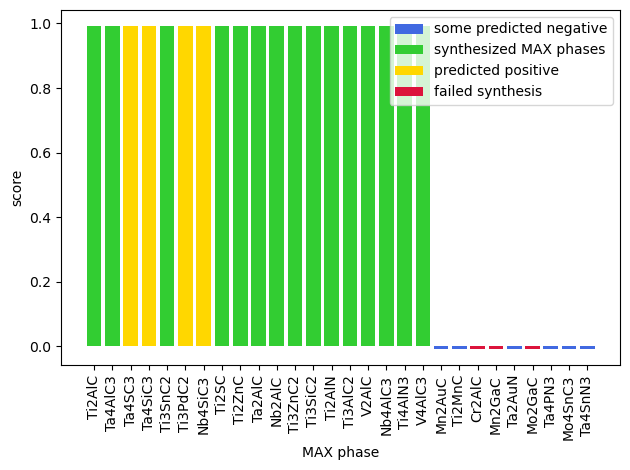

In [40]:
fig, ax = plt.subplots()
ax.bar(x=['Ti2AlC','Ti2AlC','Ti2AlC','Ti2AlC'],height=[0,0,0,0],color=['royalblue','limegreen','gold','crimson'],
       label=['some predicted negative','synthesized MAX phases','predicted positive','failed synthesis'])
ax.bar(x=updated_data_for_plot.index,
       height=updated_data_for_plot['score'], color=updated_data_for_plot['color'])
ax.set(ylabel='score')
ax.set(xlabel='MAX phase')
ax.tick_params(axis='x',labelrotation=90)
#ax.bar(x=['0','0','0','0'],height=[0,0,0,0],color=['royalblue','limegreen','gold','crimson'],
#       label=['predicted negative','synthesized MAX phases','predicted positive','failed synthesis'])
ax.legend()
plt.tight_layout()
plt.savefig('element_score_it_ls_svm.png')

In [41]:
table_of_scores = updated_data[updated_data['check_array'] == 1]
table_of_scores = table_of_scores.filter(['score','class'],axis=1)

In [42]:
table_of_scores['class'] = table_of_scores['class'].replace(to_replace=1,value='positive')

In [43]:
table_of_scores['class'] = table_of_scores['class'].replace(to_replace=0,value='unlabelled')

In [44]:
table_of_scores = table_of_scores.sort_values(by='score',ascending=False)

In [45]:
print(table_of_scores.to_latex())

\begin{tabular}{lrl}
\toprule
 & score & class \\
compound_name &  &  \\
\midrule
Ta4AlC3 & 0.991591 & positive \\
Ta4SC3 & 0.991591 & unlabelled \\
Ta4SiC3 & 0.991591 & unlabelled \\
Ti3SnC2 & 0.991591 & positive \\
Ti3PdC2 & 0.991591 & unlabelled \\
Nb4SiC3 & 0.991591 & unlabelled \\
Ti2AlC & 0.991591 & positive \\
Ti2SC & 0.991591 & positive \\
Ti2ZnC & 0.991591 & positive \\
Ta2AlC & 0.991591 & positive \\
Ti3ZnC2 & 0.991591 & positive \\
Nb2AlC & 0.991591 & positive \\
Ti3SiC2 & 0.991591 & positive \\
Ti2AlN & 0.991591 & positive \\
Ti3AlC2 & 0.991591 & positive \\
V2AlC & 0.991591 & positive \\
Nb4AlC3 & 0.991591 & positive \\
Ti4AlN3 & 0.991591 & positive \\
V4AlC3 & 0.991591 & positive \\
\bottomrule
\end{tabular}



In [48]:
convertible_to_plot = pd.read_csv('convertible_bagging.csv')
convertible_to_plot = convertible_to_plot.set_index(keys='Unnamed: 0',drop=True)

In [65]:
convertible_index = list(convertible_to_plot.index)
pred_pos_index = list(pred_pos.index)
positive_samples_index = list(positive_samples.index)
conv_to_plot = max_calculated.filter(items=convertible_index,axis=0)
conv_to_plot = conv_to_plot.filter(items=['dEf','dH'],axis=1)
pred_pos_to_plot = max_calculated.filter(items=positive_samples_index,axis=0)
pred_pos_to_plot = pred_pos_to_plot.filter(items=['dEf','dH'],axis=1)
positive_samples_to_plot = max_calculated.filter(items=positive_samples_index,axis=0)
positive_samples_to_plot = positive_samples_to_plot.filter(items=['dEf','dH'],axis=1)

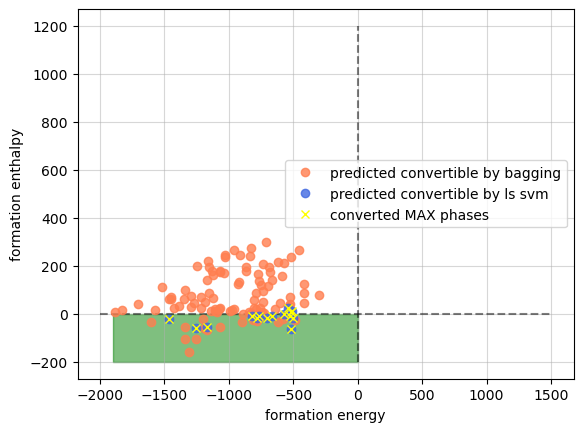

In [73]:
fig, ax = plt.subplots()
ax.grid(alpha=0.5)
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.fill_between(np.linspace(np.min(df_no_pos['dEf'].to_numpy()),0,2,endpoint=True),y1=-200,y2=0,color='green',alpha=0.5)
ax.plot(conv_to_plot['dEf'],conv_to_plot['dH'], 'o',color='coral',alpha=0.8,
       label='predicted convertible by bagging')
ax.plot(pred_pos_to_plot['dEf'],pred_pos_to_plot['dH'],'o',color='royalblue',alpha=0.8,
       label='predicted convertible by ls svm')
ax.plot(positive_samples_to_plot['dEf'],positive_samples_to_plot['dH'],'x', color='yellow', alpha=1.,
       label='converted MAX phases')
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
plt.legend()
plt.savefig('common_pred_l_4_r_119.png')